In [102]:
import ujson as json
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import requests


api_url = 'http://localhost:7070/api/ptt/query'

headers = {
    'Content-Type': 'application/json'
}

query_mix = {
        "operations": {
            "feature1" : {"type": "RETRIEVER", "field": "clip", "input": "clip"},
            "feature2" : {"type": "RETRIEVER", "field": "ocr", "input": "ocr"},
            "feature3" : {"type": "RETRIEVER", "field": "asr", "input": "asr"},
            "feature4" : {"type": "RETRIEVER", "field": "caption", "input": "caption"},
            "feature1_exaggerated": {"type": "TRANSFORMER", "transformerName": "ScoreExaggerator", "input": "feature1"},
            "feature2_exaggerated": {"type": "TRANSFORMER", "transformerName": "ScoreExaggerator", "input": "feature2"},
            "feature3_exaggerated": {"type": "TRANSFORMER", "transformerName": "ScoreExaggerator", "input": "feature3"},
            "feature4_exaggerated": {"type": "TRANSFORMER", "transformerName": "ScoreExaggerator", "input": "feature4"},
            "score" : {"type": "AGGREGATOR", "aggregatorName": "WeightedScoreFusion", "inputs": ["feature1_exaggerated", "feature2_exaggerated", "feature3_exaggerated", "feature4_exaggerated"]},
            "relations" : {"type": "TRANSFORMER", "transformerName": "RelationExpander", "input": "score"},
            "lookup" : {"type": "TRANSFORMER", "transformerName": "FieldLookup", "input": "relations"},
            "aggregator" : {"type": "TRANSFORMER", "transformerName": "ScoreAggregator",  "input": "lookup"},
            "filelookup" : {"type": "TRANSFORMER", "transformerName": "FieldLookup", "input": "aggregator"}
        },
        "context": {
            "global": {
                "limit": "1000"
            },
            "local" : {
                "feature1_exaggerated": {"factor": "1.0"},
                "feature2_exaggerated": {"factor": "1.0"},
                "feature3_exaggerated": {"factor": "1.0"},
                "feature4_exaggerated": {"factor": "1.0"},
                "lookup": {"field": "time", "keys": "start, end"},
                "relations" : {"outgoing": "partOf"},				
                "filelookup": {"field": "file", "keys": "path"},
				"score": {"weights": "0.5,0.2,0.2,0.1"}
            }
        },
        "output": "filelookup"
}

In [106]:
def query_ve(query, query_template):
    response = requests.post(api_url, json=query_template, headers=headers)

    if response.status_code == 200:
        response_data = response.json()
        return {
            "query": query,
            "response": response_data
        }
    
    else:
        print(f"Request failed with status code {response.status_code}")
        print(f"Query text: {query['query']}")
        print("Response content:", response.content)

def combined_query_ve(query, query_template, weights, p, exag_factor):
    query_template["inputs"] = {
                "clip": {"type": "TEXT", "data": query["query"]},
                "ocr": {"type": "TEXT", "data": query["query"]},
                "asr": {"type": "TEXT", "data": query["query"]},
                "caption": {"type": "TEXT", "data": query["query"]}
        }
    query_template["context"]["local"]["score"]["weights"] = weights
    query_template["context"]["local"]["feature1_exaggerated"]["factor"] = str(exag_factor[0])
    query_template["context"]["local"]["feature2_exaggerated"]["factor"] = str(exag_factor[1])
    query_template["context"]["local"]["feature3_exaggerated"]["factor"] = str(exag_factor[2])
    query_template["context"]["local"]["feature4_exaggerated"]["factor"] = str(exag_factor[3])
    query_template["context"]["global"]["p"] = str(p)
    return query_ve(query, query_template)

In [191]:
benchmark_queries = 've-benchmarking/benchmark_queries.json'
results_path = 've-benchmarking/query_results/'

with open(benchmark_queries, 'r') as file:
    queries = json.load(file)

weight_clip = 0.95
weight_ocr = (1 - weight_clip) / 3
weight_asr = (1 - weight_clip) / 3
weight_caption = (1 - weight_clip) / 3
weights = f"{weight_clip},{weight_ocr},{weight_asr},{weight_caption}"
exag_factor = [3, 0.5, 1, 1]
p = 13

# weight_clip = 1
# weight_ocr = (1 - weight_clip) / 3
# weight_asr = (1 - weight_clip) / 3
# weight_caption = (1 - weight_clip) / 3
# weights = f"{weight_clip},{weight_ocr},{weight_asr},{weight_caption}"
# exag_factor = [1, 1, 1, 1]
# p = 1

label = f"clip {weight_clip:2f} ocr {weight_ocr:2f} asr {weight_asr:2f} caption {weight_caption:2f} exag{exag_factor}_p_{p}"

results_mix = []
for query in queries:
    results_mix.append(combined_query_ve(query, query_mix, weights, p, exag_factor=exag_factor))


In [33]:
len(queries)

57

In [6]:
def iou(query, candidate):
    # convert nanoseconds to seconds
    candidate_start = int(candidate["properties"]["start"]) / 1000000000.0
    candidate_end = int(candidate["properties"]["end"]) / 1000000000.0
    truth_start = query["segments"][0][0]
    truth_end = query["segments"][0][1]

    intersection = min(truth_end,candidate_end)-max(truth_start,candidate_start)
    if intersection < 0:
        # negative intersection = no overlap = IOU 0
        return 0.0
    
    union = (candidate_end-candidate_start) + (truth_end-truth_start) - intersection
    return intersection/union

In [7]:
def format_iou(query, method, rank):
    # considers only first result
    if "segments" in query["query"] and len(query["response"]["retrievables"])>0 and "start" in query["response"]["retrievables"][rank]["properties"]: 
        iou_score = iou(query["query"],query["response"]["retrievables"][rank])
        return {
            "iou": iou_score,
            "method": method,
            "class": query["query"]["tag"][0]
        }


In [8]:
def rank(query, candidates):
    truth = query["files"]
    rank = float("inf")
    for i in range(len(candidates)):
        cand_file = os.path.basename(candidates[i]["properties"]["path"])
        if cand_file in truth:
            rank = i+1
            break

    return rank

In [9]:
def format_mrr(query, method):
    if len(query["response"]["retrievables"]) > 0:
        res_rank = rank(query["query"], query["response"]["retrievables"])
        return {
            "rank": res_rank,
            "mrr": 1.0/res_rank,
            "method": method,
            "class": query["query"]["tag"][0]
        }

## Intersection-over-union for video retrievables, MRR for image retrievables

In [147]:
iou_results = []
mrr_results = []



In [192]:

for result in results_mix:
    iou_results.append(format_iou(result, label, 0))
    mrr_results.append(format_mrr(result, label))

In [43]:
result

{'query': {'query': 'Man walking in tunnel full of cables',
  'files': ['FLM 0215_02.mp4'],
  'segments': [[570.64, 577.18]],
  'tag': ['visual']},
 'response': {'retrievables': [{'id': 'e9cc2802-54b3-4c60-98c4-364df863248e',
    'score': 0.75520647,
    'type': '',
    'parts': [],
    'properties': {'start': '570000000000',
     'end': '575000000000',
     'path': '/Users/faber0002/Documents/retrieval-with-context-benchmark/ve-benchmarking/../benchmark/media_objects/Museum für Kommunikation/Filmsammlung/FLM 0215_02.mp4'}},
   {'id': '7531c690-b854-4adf-a397-a87e75a4a28a',
    'score': 0.7145363,
    'type': '',
    'parts': [],
    'properties': {'path': '/Users/faber0002/Documents/retrieval-with-context-benchmark/ve-benchmarking/../benchmark/media_objects/Museum für Kommunikation/Fotosammlung/FFF 00102.jpg'}},
   {'id': '3b2fde62-6d8a-4a26-bf7e-4a9df3732012',
    'score': 0.7107805,
    'type': '',
    'parts': [],
    'properties': {'start': '550000000000',
     'end': '555000000

In [40]:
[r for r in iou_results if r is not None]

[{'iou': 0.0, 'method': '0.5,0.2,0.2,0.1', 'class': 'context'},
 {'iou': 0.3835877862595396, 'method': '0.5,0.2,0.2,0.1', 'class': 'audio'},
 {'iou': 0.0, 'method': '0.5,0.2,0.2,0.1', 'class': 'context'},
 {'iou': 0.16700610997963214, 'method': '0.5,0.2,0.2,0.1', 'class': 'audio'},
 {'iou': 0.2684478371501285, 'method': '0.5,0.2,0.2,0.1', 'class': 'context'},
 {'iou': 0.1571338780641106, 'method': '0.5,0.2,0.2,0.1', 'class': 'context'},
 {'iou': 0.09746835443038097, 'method': '0.5,0.2,0.2,0.1', 'class': 'audio'},
 {'iou': 0.0, 'method': '0.5,0.2,0.2,0.1', 'class': 'visual'},
 {'iou': 0.3835877862595396, 'method': '0.5,0.25,0.25,0', 'class': 'audio'},
 {'iou': 0.0, 'method': '0.5,0.25,0.25,0', 'class': 'context'},
 {'iou': 0.04668930390492335, 'method': '0.5,0.25,0.25,0', 'class': 'context'},
 {'iou': 0.6459999999999979, 'method': '0.5,0.25,0.25,0', 'class': 'audio'},
 {'iou': 0.2684478371501285, 'method': '0.5,0.25,0.25,0', 'class': 'context'},
 {'iou': 0.0, 'method': '0.5,0.25,0.25,0'

In [193]:
mrr_df = pd.DataFrame([r for r in mrr_results if r is not None])
iou_df = pd.DataFrame([r for r in iou_results if r is not None])

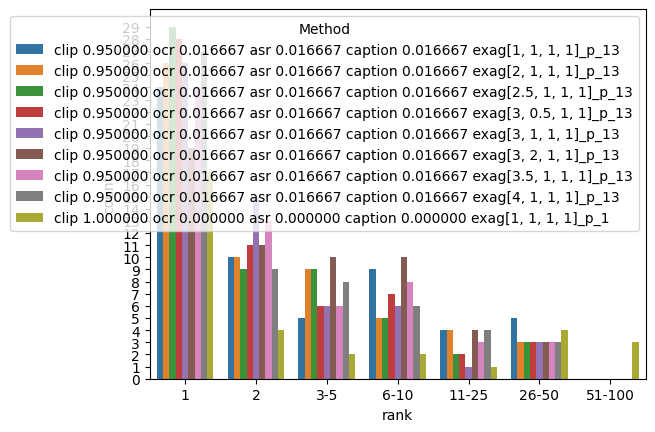

In [194]:
cutoffs = [1,2,5,10,25,50,100,200]
# Create a DataFrame with bins and counts for each method
hist_data = []
for method_group in mrr_df.groupby("method"):
    method_name, method_group = method_group
    counts, _ = np.histogram(method_group["rank"], bins=cutoffs)
    hist_data.extend({"method": method_name, "rank": bin, "count": count} for bin, count in zip(cutoffs, counts))

hist_df = pd.DataFrame(hist_data)

# Plotting side-by-side bars with the same width
sns.barplot(data=hist_df, x="rank", y="count", hue="method", dodge=True)

xticklabels = ["1", "2", "3-5", "6-10", "11-25", "26-50", "51-100"]
plt.xticks(range(len(xticklabels)), xticklabels)
plt.yticks(range(30))

# Add legend
plt.legend(title="Method")

# Show the plot
plt.show()

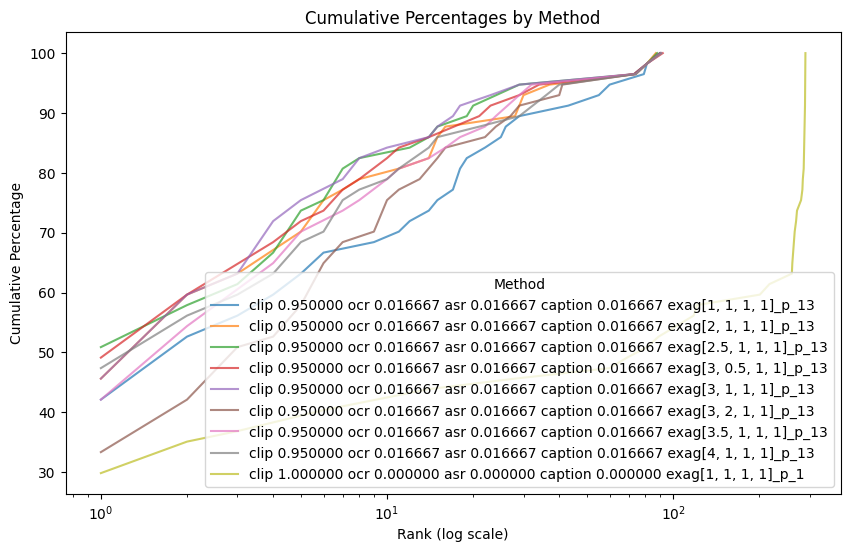

In [195]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming mrr_df is already defined and contains the data
# Example mrr_df:
# mrr_df = pd.DataFrame({
#     "method": np.random.choice(["method1", "method2", "method3"], size=100),
#     "rank": np.random.randint(1, 200, size=100)
# })

# Create a DataFrame with cumulative counts for each method without bins
cumulative_data = []
for method_name, method_group in mrr_df.groupby("method"):
    # Sort the ranks
    sorted_ranks = np.sort(method_group["rank"])
    cumulative_counts = np.arange(1, len(sorted_ranks) + 1)
    cumulative_data.extend({"method": method_name, "rank": rank, "cumulative_count": cum_count} 
                           for rank, cum_count in zip(sorted_ranks, cumulative_counts))

cumulative_df = pd.DataFrame(cumulative_data)

# Group by method and rank to sum cumulative counts
cumulative_df = cumulative_df.groupby(['method', 'rank']).size().groupby(level=0).cumsum().reset_index(name='cumulative_count')

# Normalize cumulative counts to percentages
total_counts = cumulative_df.groupby('method')['cumulative_count'].transform('max')
cumulative_df['cumulative_percent'] = (cumulative_df['cumulative_count'] / total_counts) * 100

# Plotting cumulative counts with a logarithmic x-axis
plt.figure(figsize=(10, 6))
sns.lineplot(data=cumulative_df, x="rank", y="cumulative_percent", hue="method", alpha=0.7, markers=True)

plt.xscale("log")
plt.xlabel("Rank (log scale)")
plt.ylabel("Cumulative Percentage")
plt.title("Cumulative Percentages by Method")

# Add legend
plt.legend(title="Method")

# Show the plot
plt.show()


cumulative_data[0:20]

In [137]:
mrr_df

,rank,mrr,method,class
0,1,1.000000,clip 0.950000 ocr 0.016667 asr 0.016667 captio...,single
1,1,1.000000,clip 0.950000 ocr 0.016667 asr 0.016667 captio...,multimodal
2,17,0.058824,clip 0.950000 ocr 0.016667 asr 0.016667 captio...,multimodal
3,44,0.022727,clip 0.950000 ocr 0.016667 asr 0.016667 captio...,single
4,1,1.000000,clip 0.950000 ocr 0.016667 asr 0.016667 captio...,single
...,...,...,...,...
337,1,1.000000,clip 0.950000 ocr 0.016667 asr 0.016667 captio...,audio
338,1,1.000000,clip 0.950000 ocr 0.016667 asr 0.016667 captio...,audio
339,15,0.066667,clip 0.950000 ocr 0.016667 asr 0.016667 captio...,visual
340,1,1.000000,clip 0.950000 ocr 0.016667 asr 0.016667 captio...,visual


<Axes: xlabel='class', ylabel='iou'>

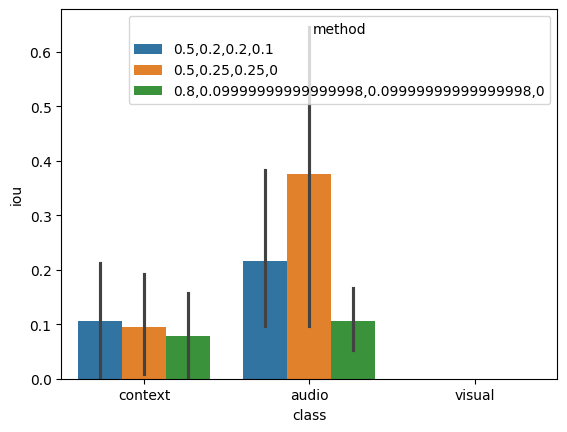

In [28]:
sns.barplot(data=iou_df, x="class", y="iou", hue="method", dodge=True)